In [1]:
import numpy as np
import argparse
import time
import cv2
import os

import matplotlib.pyplot as plt

In [2]:
print(cv2.__version__)

4.1.2


In [3]:
# load the names of the classes on which the network has been trained on.

labelsPath = "yolo-coco/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")
LABELS[0:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [4]:
# generate a random color, we will use this color later on when drawing the bounding boxes around the objects.

np.random.seed(42)
COLORS = np.random.randint(0, 255, size = (len(LABELS), 3), dtype="uint8")
COLORS[0:5]

array([[102, 220, 225],
       [ 95, 179,  61],
       [234, 203,  92],
       [  3,  98, 243],
       [ 14, 149, 245]], dtype=uint8)

In [5]:
# load the cfg file, and the pre-trained weights.

weightsPath = "yolo-coco/yolov3.weights"
configPath = "yolo-coco/yolov3.cfg"

In [6]:
# Load the YOLO model 

print("Laording YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

Laording YOLO from disk...


In [7]:
# Load the image and create a copy to compare.

image = cv2.imread("Manhattan_Tolls.jpg")
imageOrig = image.copy()
(H, W) = image.shape[:2]
(H, W)

(462, 660)

In [8]:
# determine only the *output* layer names that we need from YOLO.

# ln = net.getUnconnectedOutLayersNames()
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [9]:
# resize the image to a square one 416x416 pixels and do a forward pass through the network.

blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

In [10]:
print("YOLO took {:.6f}".format(end - start))

YOLO took 1.385151


In [11]:
boxes = []
confidences = []
classIDs = []

In [12]:
# Now let's select the bounding boxes found.

# # loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        
        if confidence > 0.15:
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

In [13]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes.

idx = cv2.dnn.NMSBoxes(boxes, confidences, 0.6, 0.2)

In [14]:
# ensure at least one detection exists

if len(idx) > 0:
    for i in idx.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        
        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

(-0.5, 659.5, 461.5, -0.5)

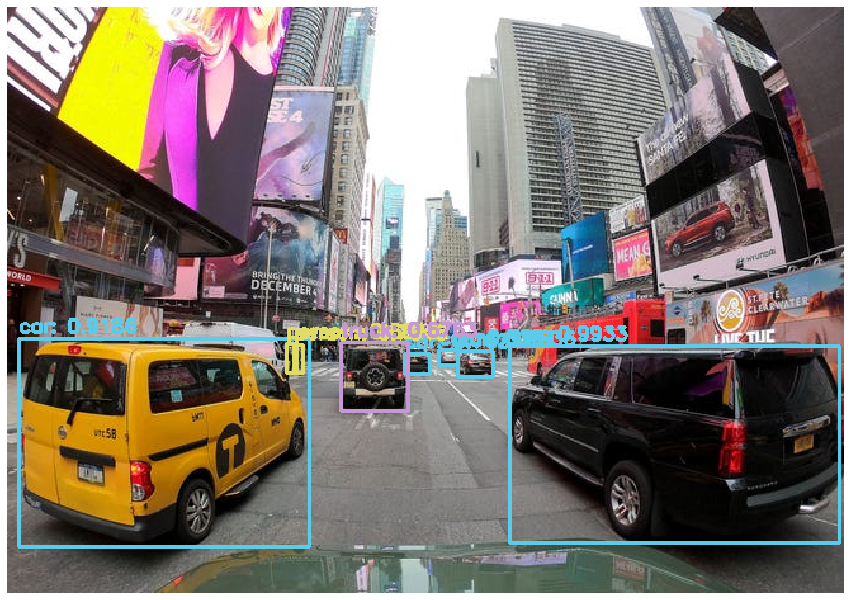

In [15]:
fig = plt.figure(figsize=(15, 12))
plt.imshow(image[:, :, ::-1])
plt.axis("off")
